In [127]:
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
from pathlib import Path
import pprint
import numpy as np
import pandas as pd
import os

In [5]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [129]:
output_dir = '.'
boc =  BrainObservatoryCache(
    manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [10]:
# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

all VISp experiment containers: 216


In [11]:
# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print("all imaging depths: " + str(depths))


all imaging depths: [175, 185, 195, 200, 205, 225, 250, 265, 275, 276, 285, 300, 320, 325, 335, 350, 365, 375, 390, 400, 550, 570, 625]


In [13]:
# Download a list of all stimuli
stims = boc.get_all_stimuli()
print("all stimuli:\n")
pprint.pprint(stims)

all stimuli:

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']


In [50]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)
cre_lines_to_use = [
    'Cux2-CreERT2',
    'Emx1-IRES-Cre',
    'Fezf2-CreER',
    'Nr5a1-Cre',
    'Ntsr1-Cre_GN220',
    'Rbp4-Cre_KL100',
    'Rorb-IRES2-Cre',
    'Scnn1a-Tg3-Cre',
    'Slc17a7-IRES2-Cre',
    'Tlx3-Cre_PL56',
]

all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


In [51]:
excitatory_ecs = boc.get_experiment_containers(cre_lines=cre_lines_to_use)
print("excitatory experiments: %d\n" % len(excitatory_ecs))

excitatory experiments: 379



Download Experiments for a Container

An experiment container is a group of experiments. Each experiment has a different stimulus protocol. For example, one experiment protocol contains the static gratings stimulus and another has the natural scenes stimulus. The BrainObservatoryCache helps you find out which experiment associated with a container has the stimuli you are interested in. First, let's see what experiments are available for a single container.

In [64]:
excitatory_ec_id = [excitatory_ecs[i]['id'] for i in range(len(excitatory_ecs))]
exps = boc.get_ophys_experiments(experiment_container_ids=excitatory_ec_id, session_types=['three_session_B'])

The session_type field indicates which experimental protocol was used. If you just want to find which experiment contains the static gratings stimulus, you can do the following:

In [ ]:
# import allensdk.brain_observatory.stimulus_info as stim_info

# # pick one of the cux2 experiment containers
# cux2_ec_id = cux2_ecs[-1]['id']

# # Find the experiment with the static static gratings stimulus
# exp = boc.get_ophys_experiments(experiment_container_ids=[cux2_ec_id], 
#                                 stimuli=[stim_info.STATIC_GRATINGS])[0]
# print("Experiment with static gratings:")
# pprint.pprint(exp)

Now we can download the NWB file for this experiment.

In [131]:
# for downloading all defined experiment sessions
for exp in exps:
    data_set = boc.get_ophys_experiment_data(exp['id'])

# print out the metadata available in the NWB file
#pprint.pprint(data_set.get_metadata())
cells = boc.get_cell_specimens() # initiate cells object. it includes properties of all neurons recorded, including orientation selectivity, etc.
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

2023-10-19 22:54:06,439 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/663511691
2023-10-19 22:54:15,001 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516247313


KeyboardInterrupt: 

In [92]:
session_data = boc.get_ophys_experiment_data(exps[1]['id'])
session_metadata = session_data.get_metadata()

In [97]:
session_cell_ids = session_data.get_cell_specimen_ids()
print(len(session_cell_ids))
session_cell_info = cells[cells['cell_specimen_id'].isin(session_cell_ids)]

128


In [107]:
session_timestamps = session_data.get_fluorescence_timestamps()

In [115]:
session_stim_epoch = session_data.get_stimulus_epoch_table()
session_stim_epoch

,stimulus,start,end
0,static_gratings,750,15235
1,natural_scenes,16141,30628
2,spontaneous,30778,39682
3,natural_scenes,39683,54167
4,static_gratings,55074,69558
5,natural_movie_one,70464,79517
6,natural_scenes,80423,96341
7,static_gratings,97624,113920


In [126]:
session_stim = session_data.get_stimulus_table(stimulus_name='natural_scenes')
np.sum(session_stim['frame']==117)

50

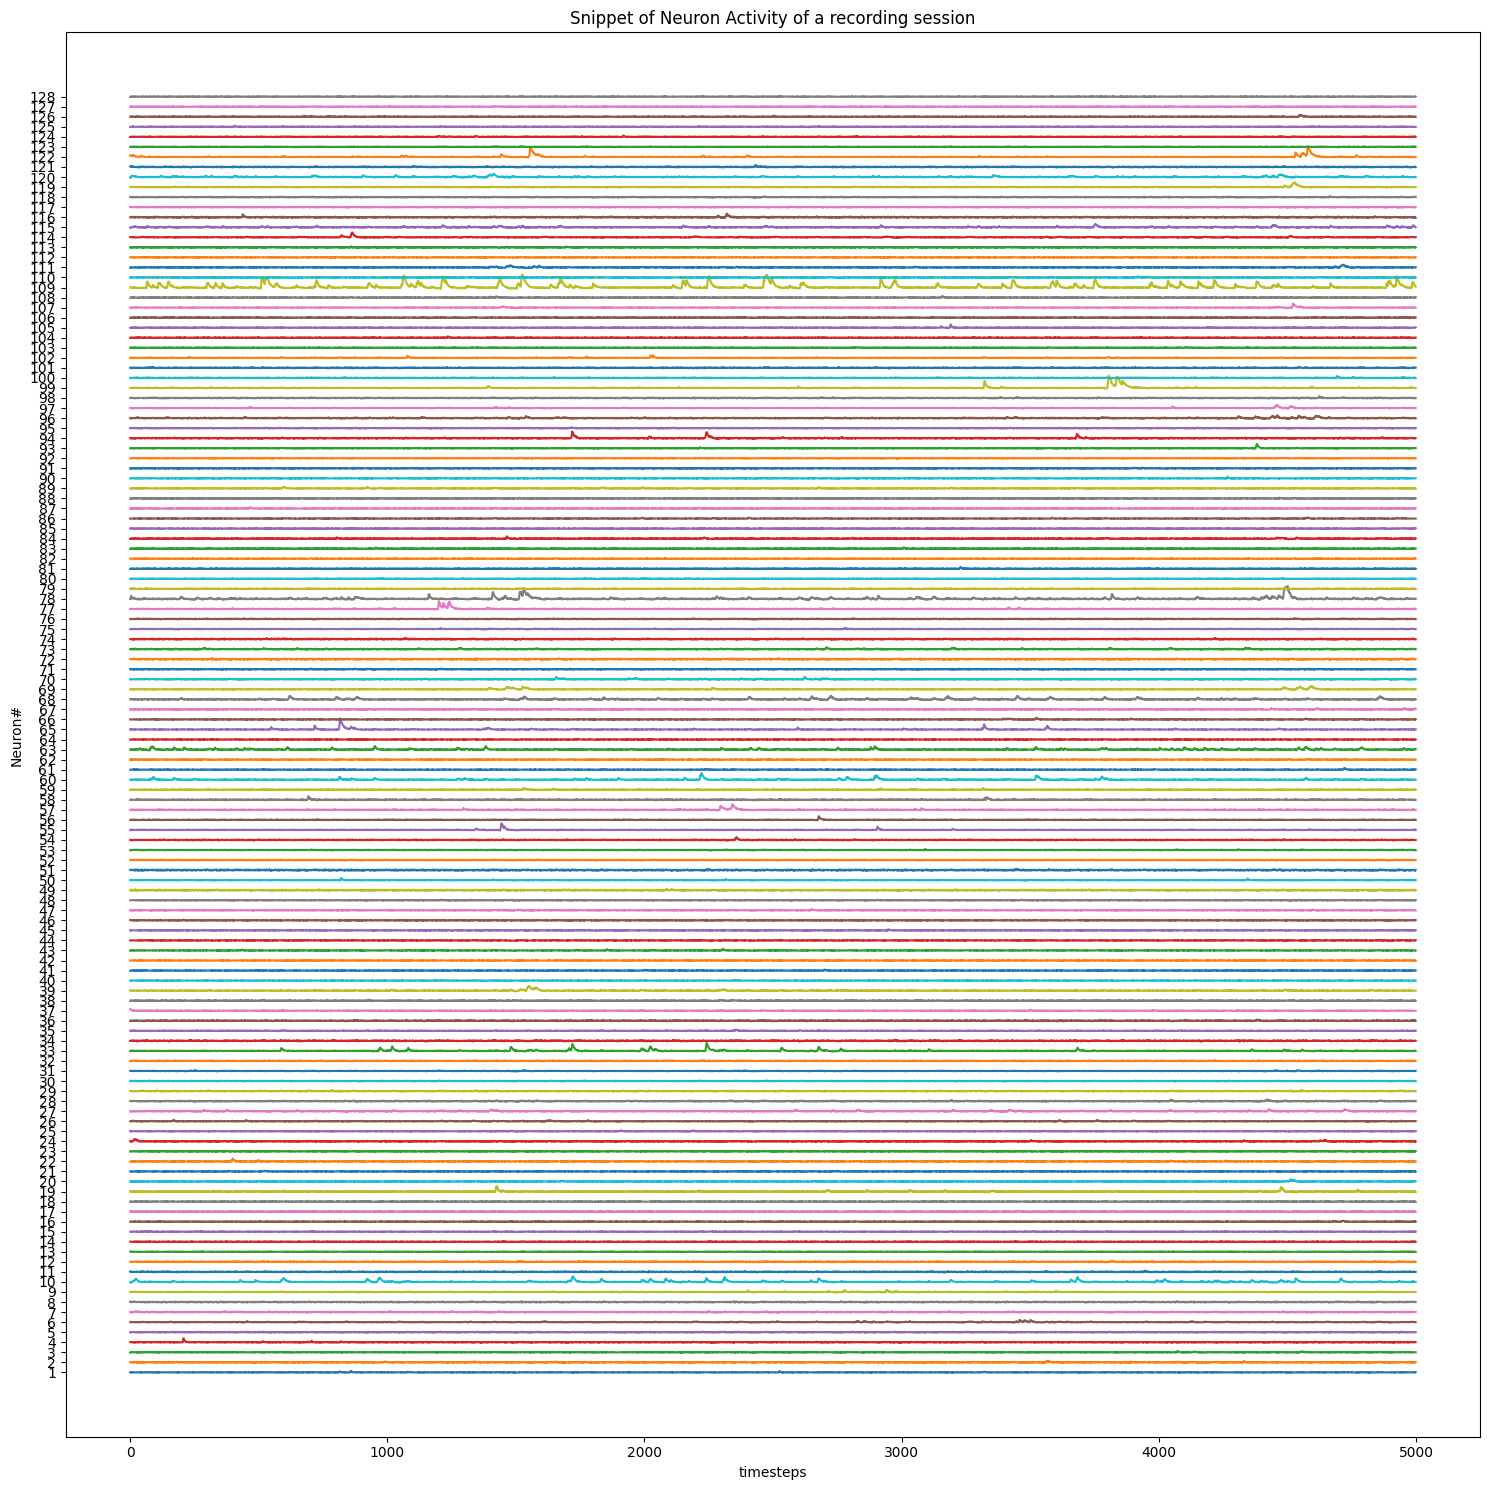

In [110]:
_, dFF = session_data.get_dff_traces()
fig = plt.figure(figsize=(15,15))
numCell = dFF.shape[0]
x_range = np.arange(10000, 15000)
for i in range(numCell):
    data = dFF[i,x_range]+(i)*3
    plt.plot(data)
    plt.xlabel('timesteps')
    plt.yticks(ticks=np.arange(numCell)*3, labels=[str(x+1) for x in np.arange(numCell)])
    plt.ylabel('Neuron#')
    plt.title('Snippet of Neuron Activity of a recording session')
plt.tight_layout()
#plt.savefig('Neuron Activity example')
